In [16]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")
print(f"number of pixels: {image_width * image_height:_}")
print(f"original image is 122MB")

image_height/2 =3194.0
number of pixels: 61_171_488
original image is 122MB


# Goal

The goal of this notebook is to check the vertical center calculation using various 0deg files and various profiles

This notebooks takes the profile files produced by the [profile](https://neutronimaging.ornl.gov/tutorials/imaging-notebooks/profile/linear-profile/) notebook.

<img src='static/screenshot_of_profile_file.png' />


In [17]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob
import platform

from ipywidgets import interactive
import ipywidgets as widgets

import pprint

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib notebook

Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*base_folder = "/SNS/VENUS/IPTS-31716/shared/NC_images/2023-06-12"*


# User input 

In [18]:
if platform.node() == "mac113775":
    top_folder = "/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis/"
elif platform.system() == "Linux":
    top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis"    
else:
    top_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever"

### set up base folder 

In [19]:
base_folder = top_folder + "/profiles/"
assert os.path.exists(base_folder)  # making sure the base folder exists

## working with various profiles and 3 different 0deg images

In [20]:
list_profile_files = glob.glob(os.path.join(base_folder, '300deg_near_ideal_x_and_y_center') + '/*.txt')
assert len(list_profile_files) > 0
print(f"{list_profile_files =}")

list_profile_files =['/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis//profiles/300deg_near_ideal_x_and_y_center/horizontal_profile.txt', '/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis//profiles/300deg_near_ideal_x_and_y_center/vertical_profile.txt']


## load profiles 

In [21]:
data_dict = {}

for _file in list_profile_files:
    
    base_file_name = os.path.basename(_file)
    
    pd_data = pd.read_csv(_file, skiprows=8)
    list_names_of_columns = pd_data.columns
    xaxis = np.asarray(pd_data.loc[:, list_names_of_columns[0]])
    profile = np.asarray(pd_data.loc[:, list_names_of_columns[1]])
    
    _dict = {'xaxis': xaxis,
             'profile': profile,
             }
    
    data_dict[base_file_name] = _dict

In [22]:
# pprint.pprint(data_dict)

# fitting horizontal and vertical profile

In [23]:
estimated_center = {'horizontal_profile.txt': 4456,    # 4456
                    'vertical_profile.txt': 2912}

In [24]:
mod = lmfit.models.GaussianModel() + lmfit.models.ConstantModel()

profile_fitted_dict = {}
for _key in data_dict.keys():
    # _key being the profile file name
    
    xaxis = data_dict[_key]['xaxis']
    profile_dict = {}
    yaxis = data_dict[_key]['profile']

    pars = mod.make_params(c=yaxis.mean(),
                  center=estimated_center[_key],
                  sigma=xaxis.std(),
                  amplitude=xaxis.std() * yaxis.ptp())
    out = mod.fit(yaxis, pars, x=xaxis)

    profile_fitted_dict[_key] = {'center_value': round(out.params['center'].value),
                          'center_error': out.params['center'].stderr,
                          'fitting': out.best_fit,
                          }


In [25]:
# profile_fitted_dict

## Let's plot the center of the beam found over the image 

In [26]:
base_folder = top_folder + "/median_data/"
image_filename = os.path.join(base_folder, '300deg_nbr1_30s_frames_OB.tif')
assert os.path.exists(image_filename)

In [27]:
image = np.asarray(Image.open(image_filename))

center_x = profile_fitted_dict['horizontal_profile.txt']['center_value']
center_x_error = profile_fitted_dict['horizontal_profile.txt']['center_error']

center_y = profile_fitted_dict['vertical_profile.txt']['center_value']
center_y_error = profile_fitted_dict['vertical_profile.txt']['center_error']



<IPython.core.display.Javascript object>


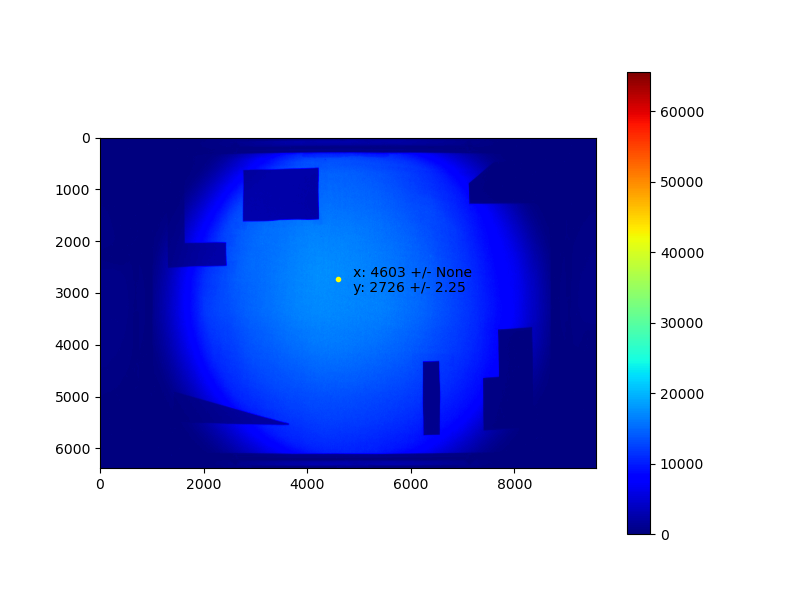

In [28]:
text_offset = 30

plt.figure(num=0, figsize=(8, 6))
plt.imshow(image, cmap='jet')
plt.errorbar(center_x, center_y, xerr=center_x_error, yerr=center_y_error, color='yellow', ecolor='black', fmt='.')
plt.colorbar()
plt.text(center_x+text_offset, center_y+text_offset,
         f"   x: {center_x} +/- {center_x_error}\n   y: {center_y} +/- {center_y_error:.2f}",
                 horizontalalignment='left',
         verticalalignment='center'
)
plt.show()

## Let's check the fitting

I'm trying to figure out why the fitting x axis is None!

In [29]:
# data_dict

In [30]:
# profile_fitted_dict

<IPython.core.display.Javascript object>


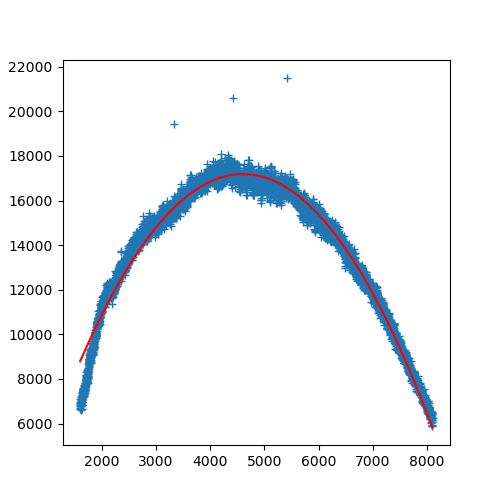

In [31]:
plt.figure(figsize=(5, 5), num="Horizontal profile")

xaxis = data_dict['horizontal_profile.txt']['xaxis']
yaxis_fitted = profile_fitted_dict['horizontal_profile.txt']['fitting']
yaxis = data_dict['horizontal_profile.txt']['profile']
plt.plot(xaxis, yaxis, '+')
plt.plot(xaxis, yaxis_fitted, 'r')

<IPython.core.display.Javascript object>


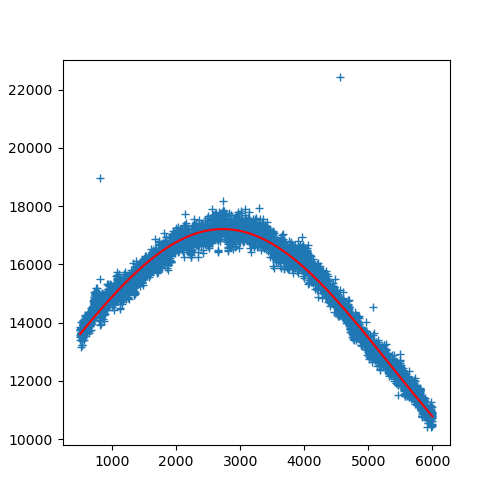

In [32]:
plt.figure(figsize=(5, 5), num="Vertical profile")

xaxis = data_dict['vertical_profile.txt']['xaxis']
yaxis_fitted = profile_fitted_dict['vertical_profile.txt']['fitting']
yaxis = data_dict['vertical_profile.txt']['profile']
plt.plot(xaxis, yaxis, '+')
plt.plot(xaxis, yaxis_fitted, 'r')

Maybe we should start the fitting using the range [2148, 8000] and remove the high counts (above 19000)

# Let's now find the corresponding spacial coordinates of that center

Ideally it should be (0, 0) !

<img src='static/markers_position.png' />

### Let's find the x position of those corners using Fiji

Because the corners look like this

<img src='static/zoom_of_mask_corner.png' />

we need to get the profile of the edges, then fit in order to figure out the center of those edges.

**NB:** This will also allow us to determine the resolution of the camera

#### load the profiles 

In [33]:
base_folder = top_folder + "/profiles/edges_profile"
list_profiles_files = glob.glob(os.path.join(base_folder, "*.txt"))
assert len(list_profiles_files) > 0


In [34]:
list_profiles_files

['/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis//profiles/edges_profile/horizontal_profile_of_mask1.txt',
 '/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis//profiles/edges_profile/horizontal_profile_of_mask2.txt',
 '/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis//profiles/edges_profile/vertical_profile_of_mask1.txt',
 '/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis//profiles/edges_profile/vertical_profile_of_mask2.txt']

In [35]:
profiles_dict = {}

for _file in list_profiles_files:
    
#     print(_file)
    base_file_name = os.path.basename(_file)
    
    pd_data = pd.read_csv(_file, skiprows=9)
    list_names_of_columns = pd_data.columns
    xaxis = np.asarray(pd_data.loc[:, list_names_of_columns[0]])
    profile = np.asarray(pd_data.loc[:, list_names_of_columns[1]])
    
    _dict = {'xaxis': xaxis,
             'profile': profile,
             }
    
    profiles_dict[base_file_name] = _dict

<IPython.core.display.Javascript object>


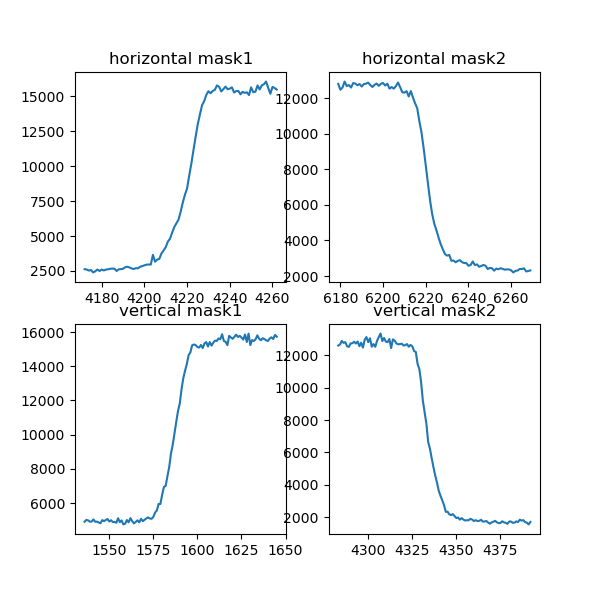

Text(0.5, 1.0, 'vertical mask2')

In [36]:
xaxis_hori_mask1 = profiles_dict['horizontal_profile_of_mask1.txt']['xaxis']
yaxis_hori_mask1 = profiles_dict['horizontal_profile_of_mask1.txt']['profile']

xaxis_hori_mask2 = profiles_dict['horizontal_profile_of_mask2.txt']['xaxis']
yaxis_hori_mask2 = profiles_dict['horizontal_profile_of_mask2.txt']['profile']

xaxis_verti_mask1 = profiles_dict['vertical_profile_of_mask1.txt']['xaxis']
yaxis_verti_mask1 = profiles_dict['vertical_profile_of_mask1.txt']['profile']

xaxis_verti_mask2 = profiles_dict['vertical_profile_of_mask2.txt']['xaxis']
yaxis_verti_mask2 = profiles_dict['vertical_profile_of_mask2.txt']['profile']

fig, axes = plt.subplots(nrows=2, ncols=2, num=10, figsize=(6, 6))

axes[0][0].plot(xaxis_hori_mask1, yaxis_hori_mask1)
axes[0][0].set_title("horizontal mask1")

axes[0][1].plot(xaxis_hori_mask2, yaxis_hori_mask2)
axes[0][1].set_title("horizontal mask2")

axes[1][0].plot(xaxis_verti_mask1, yaxis_verti_mask1)
axes[1][0].set_title("vertical mask1")

axes[1][1].plot(xaxis_verti_mask2, yaxis_verti_mask2)
axes[1][1].set_title("vertical mask2")


We will calculate the inflection point using the sliding average algorithm

In [37]:
class MeanRangeCalculation:
    '''
    Mean value of all the counts between left_pixel and right pixel
    '''

    def __init__(self, data=None):
        self.data = data
        self.nbr_pixel = len(self.data)

    def calculate_left_right_mean(self, pixel=-1):
        _data = self.data
        _nbr_pixel = self.nbr_pixel

        self.left_mean = np.nanmean(_data[0:pixel+1])
        self.right_mean = np.nanmean(_data[pixel+1:_nbr_pixel])

    def calculate_delta_mean_square(self):
        self.delta_square = np.square(self.left_mean - self.right_mean)

In [38]:
def calculate_peak_position(xaxis, yaxis):
    _o_range = MeanRangeCalculation(data=yaxis)
    delta_array = []
    for _pixel in np.arange(0, len(yaxis)-5):
        _o_range.calculate_left_right_mean(pixel=_pixel)
        _o_range.calculate_delta_mean_square()
        delta_array.append(_o_range.delta_square)

    peak_value = delta_array.index(max(delta_array[0: len(yaxis)-5]))
    return xaxis[peak_value]

In [39]:
peak_positions = {}

In [40]:
peak_positions['horizontal_profile_of_mask1'] = calculate_peak_position(xaxis_hori_mask1,
                                                                        yaxis_hori_mask1)

peak_positions['horizontal_profile_of_mask2'] = calculate_peak_position(xaxis_hori_mask2,
                                                                        yaxis_hori_mask2)

peak_positions['vertical_profile_of_mask1'] = calculate_peak_position(xaxis_verti_mask1,
                                                                      yaxis_verti_mask1)

peak_positions['vertical_profile_of_mask2'] = calculate_peak_position(xaxis_verti_mask2,
                                                                      yaxis_verti_mask2)

<IPython.core.display.Javascript object>


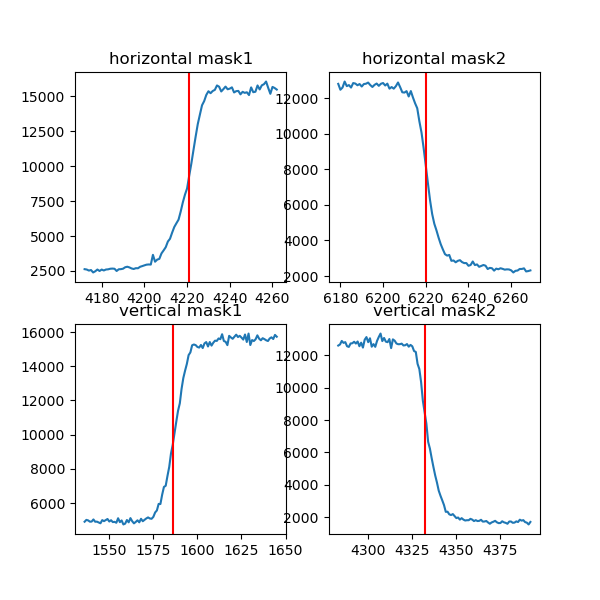

Text(0.5, 1.0, 'vertical mask2')

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, num=11, figsize=(6, 6))

axes[0][0].plot(xaxis_hori_mask1, yaxis_hori_mask1)
x = peak_positions['horizontal_profile_of_mask1']
axes[0][0].axvline(x, color='r')
axes[0][0].set_title("horizontal mask1")

axes[0][1].plot(xaxis_hori_mask2, yaxis_hori_mask2)
x = peak_positions['horizontal_profile_of_mask2']
axes[0][1].axvline(x, color='r')
axes[0][1].set_title("horizontal mask2")

axes[1][0].plot(xaxis_verti_mask1, yaxis_verti_mask1)
x = peak_positions['vertical_profile_of_mask1']
axes[1][0].axvline(x, color='r')
axes[1][0].set_title("vertical mask1")

axes[1][1].plot(xaxis_verti_mask2, yaxis_verti_mask2)
x = peak_positions['vertical_profile_of_mask2']
axes[1][1].axvline(x, color='r')
axes[1][1].set_title("vertical mask2")


<IPython.core.display.Javascript object>


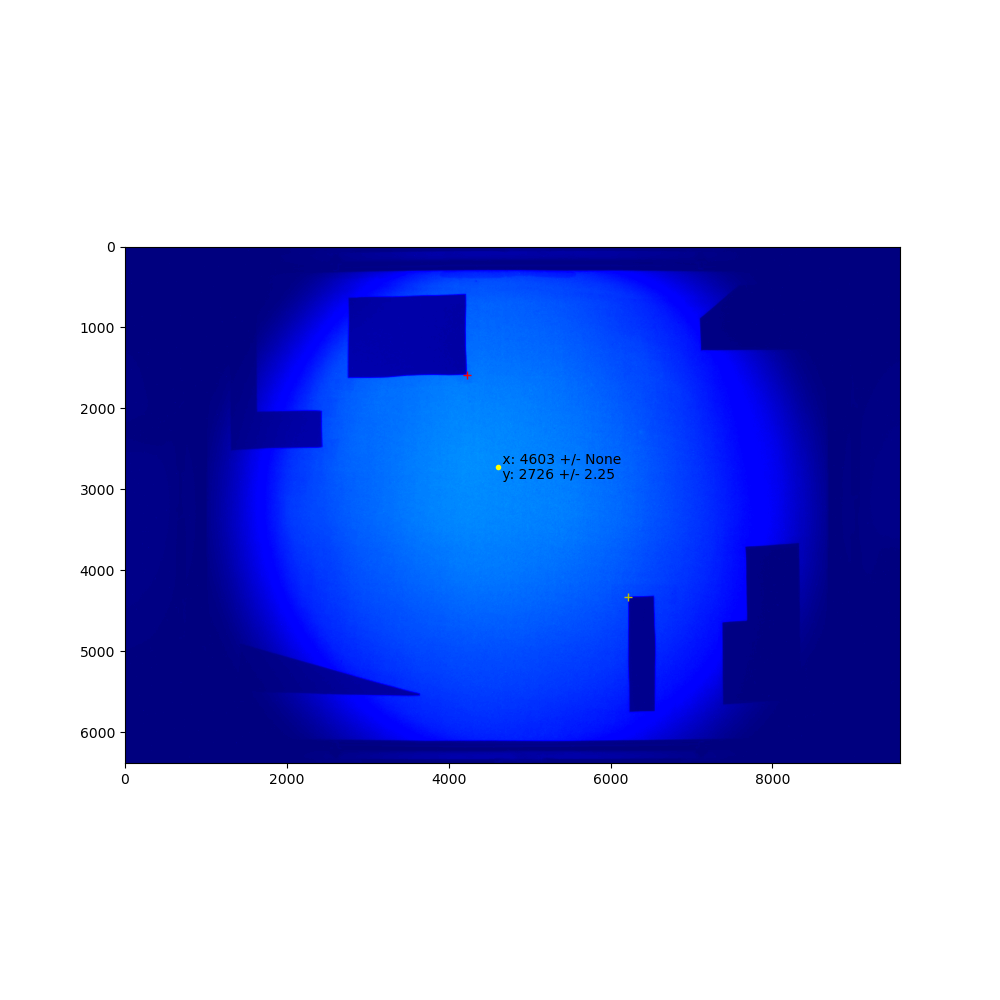

In [42]:
plt.figure(num=12, figsize=(10, 10))
plt.imshow(image, cmap='jet')
plt.errorbar(center_x, center_y, xerr=center_x_error, yerr=center_y_error, color='yellow', ecolor='black', fmt='.')
plt.text(center_x, center_y,
         f" x: {center_x} +/- {center_x_error}\n y: {center_y} +/- {center_y_error:.2f}",
                 horizontalalignment='left',
         verticalalignment='center'
)

x1 = peak_positions['horizontal_profile_of_mask1']
y1 = peak_positions['vertical_profile_of_mask1'] 
plt.plot(x1, y1, '+r')

x2 = peak_positions['horizontal_profile_of_mask2']
y2 = peak_positions['vertical_profile_of_mask2'] 
plt.plot(x2, y2, '+y')



In [60]:
print(x2) # 6220
print(x1) # 4221

print(y2) # 4332
print(y1) # 1586

6220
4221
4332
1586


In [43]:
real_x1 = 33.969
real_y1 = 84.191

real_x2 = -70.698
real_y2 = -57.584

x = center_x
y = center_y

# what we are looking for
real_x = None
real_y = None

In [44]:
real_x = np.round(((real_x2 - real_x1)/(x2-x1))*(x - x1) + real_x1)
real_y = np.round(((real_y2 - real_y1)/(y2-y1))*(y - y1) + real_y1)

In [45]:
print(f"{real_x =}")
print(f"{real_y =}")

real_x =14.0
real_y =25.0


# Let's display the "ideal" center of coordinates in the image 

We are trying to find the perfect center position in pixel value

In [46]:
x1 = peak_positions['horizontal_profile_of_mask1']
y1 = peak_positions['vertical_profile_of_mask1'] 

x2 = peak_positions['horizontal_profile_of_mask2']
y2 = peak_positions['vertical_profile_of_mask2'] 

In [47]:
print(f"{real_x1}mm is at {x1}px")
print(f"{real_y1}mm is at {y1}px")
print(f"")

print(f"{real_x2}mm is at {x2}px")
print(f"{real_y2}mm is at {y2}px")

print(f"")
print(f"x: 0mm is at ?px")
print(f"y: 0mm is at ?px")

33.969mm is at 4221px
84.191mm is at 1586px

-70.698mm is at 6220px
-57.584mm is at 4332px

x: 0mm is at ?px
y: 0mm is at ?px


In [48]:
perfect_center_x_px = (x2-x1)/(real_x2 - real_x1)*(0-real_x1) + x1
print(f"perfect_center_x_px: {perfect_center_x_px}")

perfect_center_y_px = (y2-y1)/(real_y2 - real_y1)*(0-real_y1) + y1
print(f"perfect_center_y_px: {perfect_center_y_px}")

perfect_center_x_px: 4869.762561265728
perfect_center_y_px: 3216.671740433786


<IPython.core.display.Javascript object>


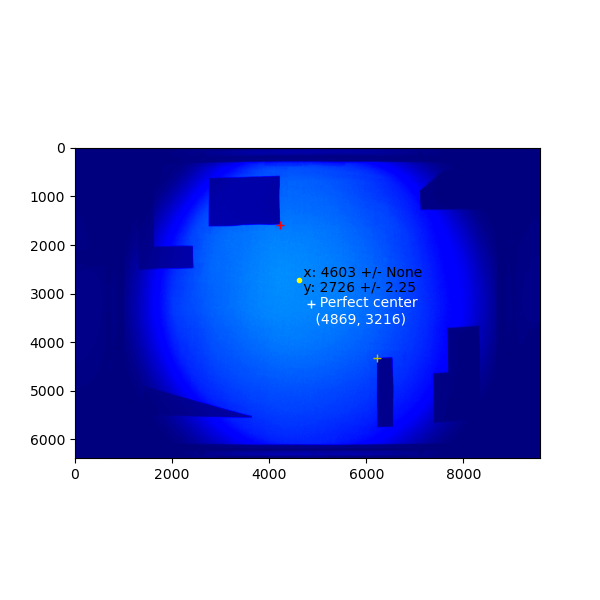

In [57]:
plt.figure(num="ideal center", figsize=(6, 6))
plt.imshow(image, cmap='jet')
plt.errorbar(center_x, center_y, xerr=center_x_error, yerr=center_y_error, color='yellow', ecolor='black', fmt='.')
plt.text(center_x, center_y,
         f" x: {center_x} +/- {center_x_error}\n y: {center_y} +/- {center_y_error:.2f}",
                 horizontalalignment='left',
         verticalalignment='center'
)

plt.plot(perfect_center_x_px, perfect_center_y_px, '+w')
plt.text(perfect_center_x_px, perfect_center_y_px +400, f"  Perfect center\n ({int(perfect_center_x_px)}, " +
         f"{int(perfect_center_y_px)})", color="white")

x1 = peak_positions['horizontal_profile_of_mask1']
y1 = peak_positions['vertical_profile_of_mask1'] 
plt.plot(x1, y1, '+r')

x2 = peak_positions['horizontal_profile_of_mask2']
y2 = peak_positions['vertical_profile_of_mask2'] 
plt.plot(x2, y2, '+y')

# Calculate pixel size 

For this, we are going to use the two edges of the top mask and count how many pixel it covers

In [80]:
base_folder = top_folder + "/profiles/calculate_pixel_size"
list_files_to_calculate_pixel_size = glob.glob(os.path.join(base_folder, "*.txt"))
assert len(list_files_to_calculate_pixel_size) > 0
list_files_to_calculate_pixel_size

['/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/calculate_pixel_size/left_edge.txt',
 '/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/calculate_pixel_size/right_edge.txt']

In [82]:
pixel_size_dict = {}

for _file in list_files_to_calculate_pixel_size:
    
    print(_file)
    base_file_name = os.path.basename(_file)
    
    pd_data = pd.read_csv(_file, skiprows=9)
    list_names_of_columns = pd_data.columns
    xaxis = np.asarray(pd_data.loc[:, list_names_of_columns[0]])
    profile = np.asarray(pd_data.loc[:, list_names_of_columns[1]])
    
    _dict = {'xaxis': xaxis,
             'profile': profile,
             }
    
    pixel_size_dict[base_file_name] = _dict

/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/calculate_pixel_size/left_edge.txt
/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/calculate_pixel_size/right_edge.txt


<IPython.core.display.Javascript object>


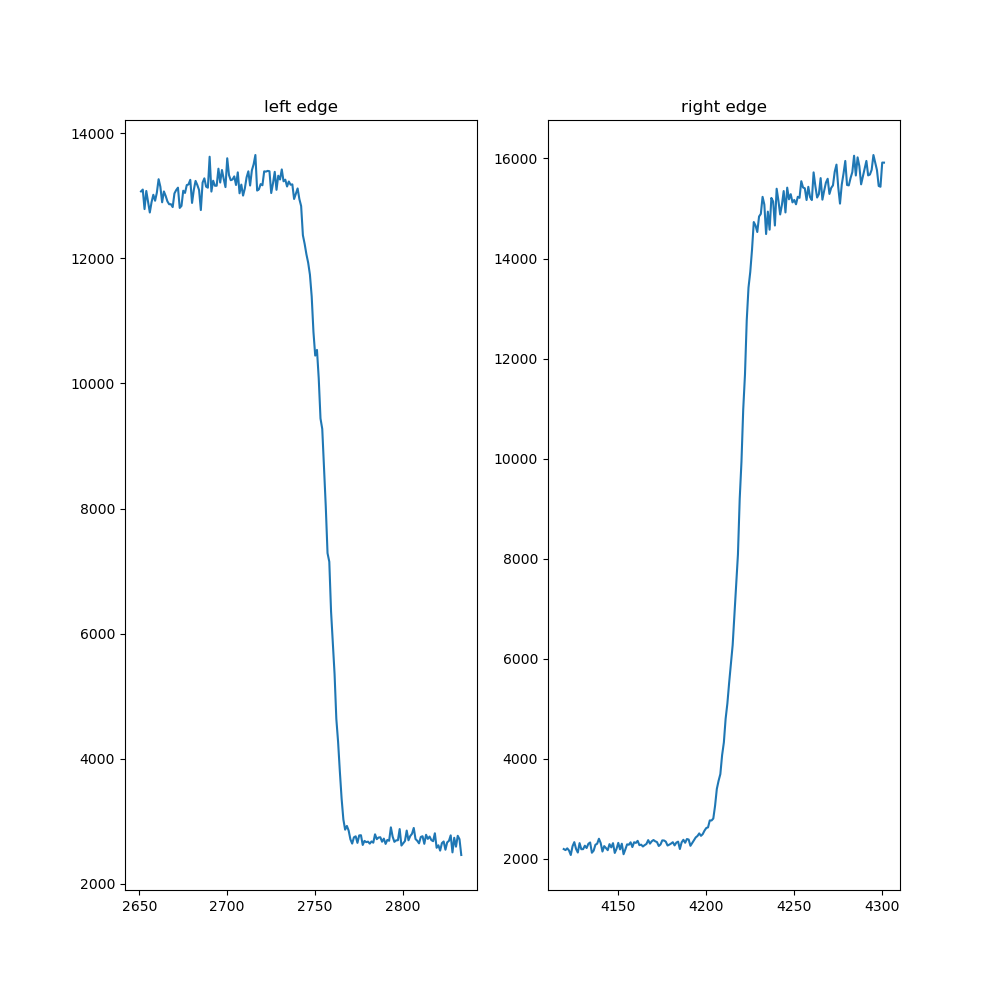

Text(0.5, 1.0, 'right edge')

In [83]:
xaxis_hori_mask1 = pixel_size_dict['left_edge.txt']['xaxis']
yaxis_hori_mask1 = pixel_size_dict['left_edge.txt']['profile']

xaxis_hori_mask2 = pixel_size_dict['right_edge.txt']['xaxis']
yaxis_hori_mask2 = pixel_size_dict['right_edge.txt']['profile']

fig, axes = plt.subplots(nrows=1, ncols=2, num=20, figsize=(10, 10))

axes[0].plot(xaxis_hori_mask1, yaxis_hori_mask1)
axes[0].set_title("left edge")

axes[1].plot(xaxis_hori_mask2, yaxis_hori_mask2)
axes[1].set_title("right edge")



In [84]:
peak_pixel_size_position = {}

peak_pixel_size_position['left_edge'] = calculate_peak_position(xaxis_hori_mask1,
                                                                yaxis_hori_mask1)

peak_pixel_size_position['right_edge'] = calculate_peak_position(xaxis_hori_mask2,
                                                                 yaxis_hori_mask2)

<IPython.core.display.Javascript object>


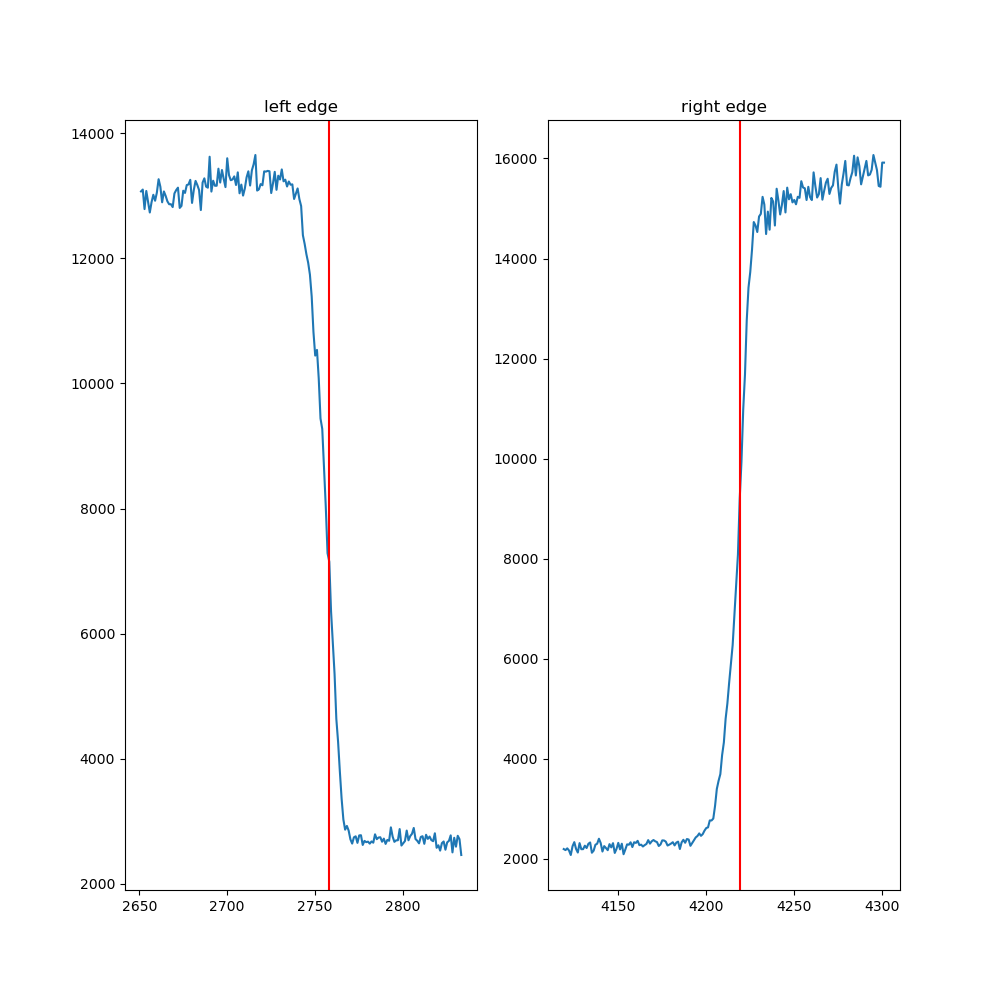

Text(0.5, 1.0, 'right edge')

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2, num=21, figsize=(10, 10))

axes[0].plot(xaxis_hori_mask1, yaxis_hori_mask1)
x = peak_pixel_size_position['left_edge']
axes[0].axvline(x, color='r')
axes[0].set_title("left edge")

axes[1].plot(xaxis_hori_mask2, yaxis_hori_mask2)
x = peak_pixel_size_position['right_edge']
axes[1].axvline(x, color='r')
axes[1].set_title("right edge")


In [86]:
left_edge = peak_pixel_size_position['left_edge']
right_edge = peak_pixel_size_position['right_edge']
number_pixels = right_edge - left_edge

print(f"{left_edge =}")
print(f"{right_edge =}")

left_edge_coordinates = 108.494  # mm
right_edge_coordinates = 33.969   # mm
length_of_edge = np.abs(left_edge_coordinates - right_edge_coordinates)

print(f"{number_pixels =}")
print(f"{length_of_edge =}")


left_edge =2758
right_edge =4219
number_pixels =1461
length_of_edge =74.525


In [87]:
print(f"Pixel size is {(length_of_edge / number_pixels)*1e3:.3f} microns")

Pixel size is 51.010 microns
